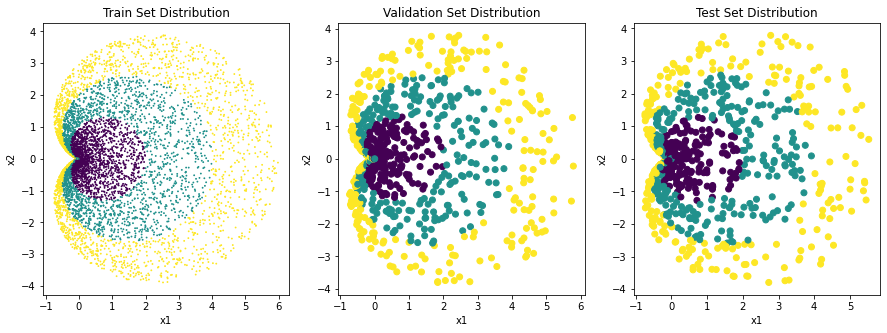

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Generate Dataset
r = np.random.rand(10000) * 3    # 0, 1, 2
theta = np.random.rand(10000) * 2 * np.pi
y = r.astype(int) # numpy에서 소수를 정수형으로 모두 바꾼다
r = r * (np.cos(theta) + 1)
x1 = r * np.cos(theta)
x2 = r * np.sin(theta)
X = np.array([x1, x2]).T

# Split Dataset into Train, Validation, Test
train_X, train_y = X[:8000, :], y[:8000]
val_X, val_y = X[8000:9000, :], y[8000:9000]
test_X, test_y = X[9000:, :], y[9000:]

# Visualize Each Dataset
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=0.7)   # c는 class를 색으로 표현하기 위함
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Train Set Distribution')


ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(val_X[:, 0], val_X[:, 1], c=val_y)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Validation Set Distribution')

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_title('Test Set Distribution')

plt.show()

## 2. Hypothesis Define (Model Define)
Logistic Regression Model을 파이토치로 구현할 때는 Regression 문제를 풀 때와 똑같이 nn.Linear 모듈과 non-linear activation fuction만 달아주면 됩니다. Model 내에서 Softmax를 사용할 필요가 없습니다..! 그 이유는 softmax 함수가 뒤에 나오는 파이썬 내장 CrossEntropyLoss 함수에 들어가 있기 때문이죠.

Multi-Label Logistic Model
$$z = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 3}, b \in \mathcal{R}^{3}, z \in \mathcal{R}^{N \times 3}$$
$$H = \ softmax(z) \ \ (  H \in \mathcal{R}^{N \times 3})$$

MLP Model$$Let \ relu(X) = \ max(X, 0)$$

$$h = \ relu(X W_1 + b_1) \ \  ( W_1 \in \mathcal{R}^{2 \times 200}, b_1 \in \mathcal{R}^{200}, h \in \mathcal{R}^{N \times 200}$$
$$z = \ h W_2 + b_2  \ \  ( W_2 \in \mathcal{R}^{200 \times 3}, b_2 \in \mathcal{R}^{3}, z \in \mathcal{R}^{N  \times 3})$$
$$H = \ softmax(z) \ \ ( H \in \mathcal{R}^{N \times 3})$$

In [52]:
import torch
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=3, bias=True)
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        x = self.linear(x)
        #x = self.softmax(x) # nn.CrossEntropyLoss에는 softmax가 구현되어있으므로 사용하지 않는다.
        return x

## 3. Cost Function Define (Loss Function Define)
Multi-Label Problem 에서의 Loss Function을 작성해봅시다.
파이토치의 nn 아래에는 다양한 Loss Function이 이미 구현되어 있습니다.
여기에서 파이토치 내부에 구현되어 있는 MSE, Cross-Entropy, KL-Divergence 등을 확인할 수 있습니다.
이 실습에서는 Classification Problem 이므로 CrossEntropyLoss()를 사용해봅시다.

input은 $ N \times Num Class $ 차원을 가지면 되며 float 형태여야 하고,
target은 $ N $ 차원을 가지고 각 엘리먼트는 $ i $ 번째 클래스를 나타내는 int형이면 되는군요.

CrossEntropy Documentation : https://pytorch.org/docs/stable/nn.html#crossentropyloss

In [53]:
cls_loss = nn.CrossEntropyLoss()

test_pred_y = torch.Tensor([[1, 0], [0, 1]])
test_true_y1 = torch.Tensor([1, 0]).long() # 확률 값이 아닌 몇 번째 클래스인지만 표시
test_true_y2 = torch.Tensor([0, 1]).long()

print(cls_loss(test_pred_y, test_true_y1))
print(cls_loss(test_pred_y, test_true_y2))

tensor(1.3133)
tensor(0.3133)


## 4. Train & Evaluation
이제 모델도 정의했고 Loss Function도 정의했으니 한번 학습시켜볼까요?
저번에는 저희가 직접 파라미터(w 하나)에 따른 loss의 편미분을 유도하고 거기서 나온 그라디언트로 w를 업데이트했는데요.
pytorch에서는 loss.backward() 라는 기능을 쓰면 알아서 loss를 계산되는데 사용한 각 파라미터에 대한 loss의 편미분을 계산해줍니다.
이후 optimizer.step() 함수를 사용하면 각 파라미터의 그라디언트를 바탕으로 파라미터의 값을 조금씩 업데이트 해줍니다.

이 때 모델은 매 Iteration 때마다 Train Set에 의해 학습되면서 동시에 Validation Set을 넣고 Loss를 비교하게 됩니다. 그리고 저희가 평가하고 싶은 때마다 (지금은 200번) Test Set을 넣고 Visualize 하는데 필요한 Predicted y값과 Metric 값을 계산합니다.
이번에는 Classification Task에서 기본적으로 사용하는 Accuracy를 Metric으로 활용해보겠습니다.
accuracy를 계산하는 함수가 이미 sklearn.metrics에 구현되어 있으니 불러와 사용하도록 합시다.

accuracy_score Documentation : <h6>https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html</h6>

$$ Accuracy = \frac{Number \ of \ correct \ prediction}{Total \ number \ of \ predictions \ made} $$

9 parameters


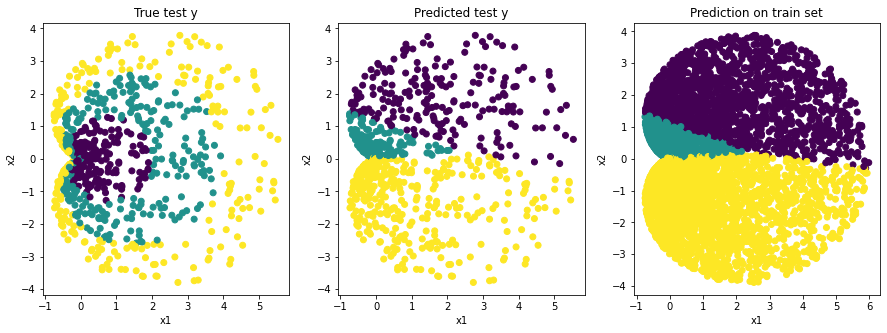

Epoch:  0 Accuracy:  26.200000000000003 %


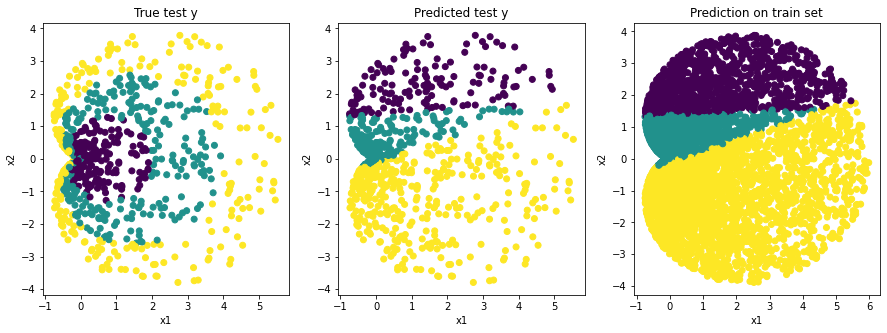

Epoch:  200 Accuracy:  28.599999999999998 %


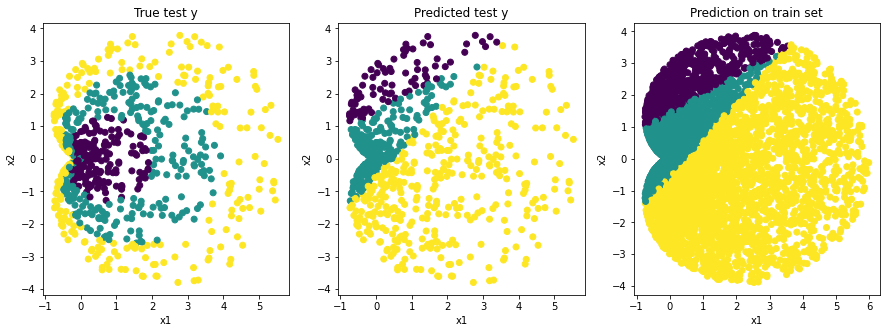

Epoch:  400 Accuracy:  31.8 %


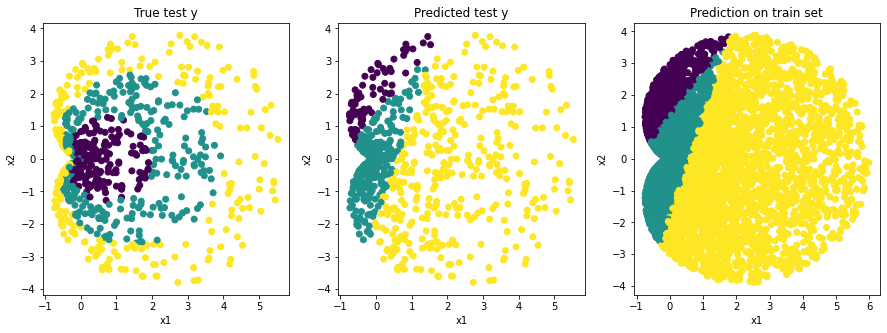

Epoch:  600 Accuracy:  31.2 %


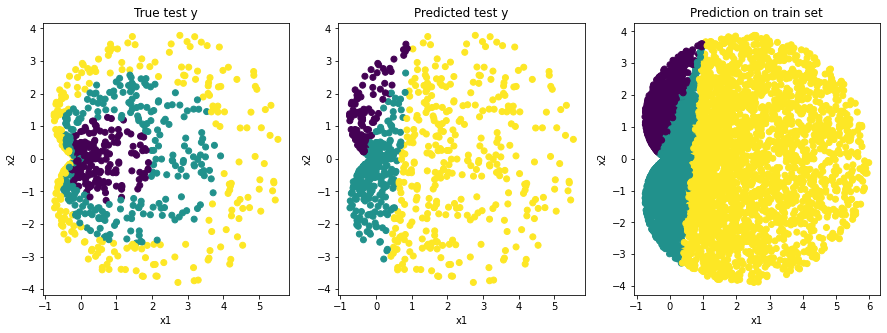

Epoch:  800 Accuracy:  28.299999999999997 %


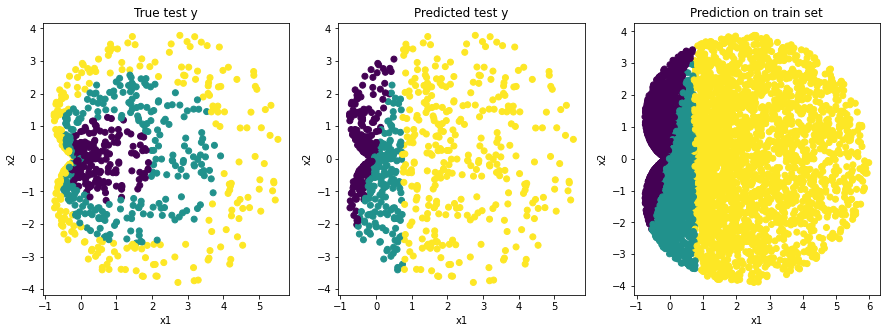

Epoch:  1000 Accuracy:  29.5 %


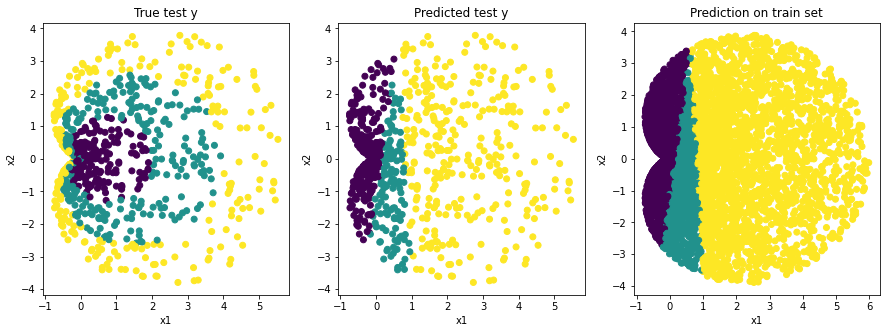

Epoch:  1200 Accuracy:  39.1 %


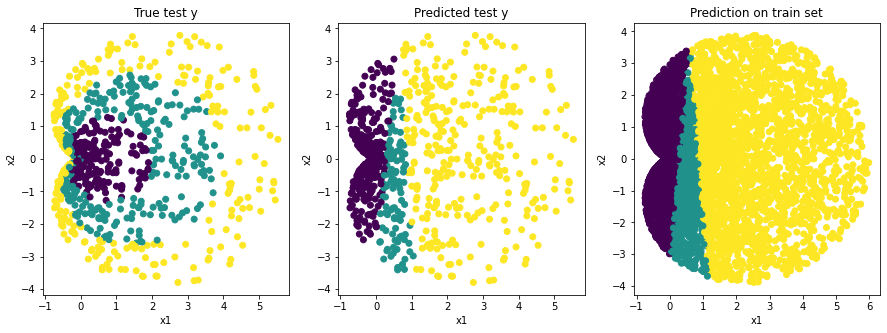

Epoch:  1400 Accuracy:  39.6 %


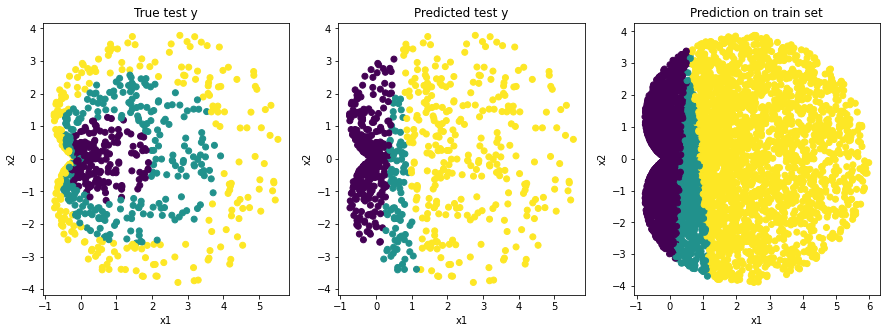

Epoch:  1600 Accuracy:  40.699999999999996 %


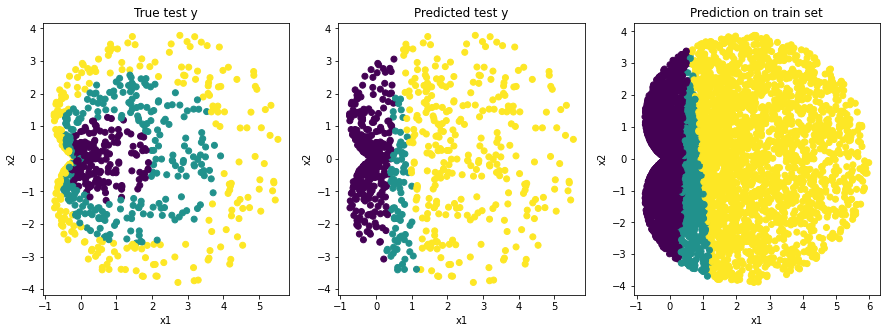

Epoch:  1800 Accuracy:  41.0 %


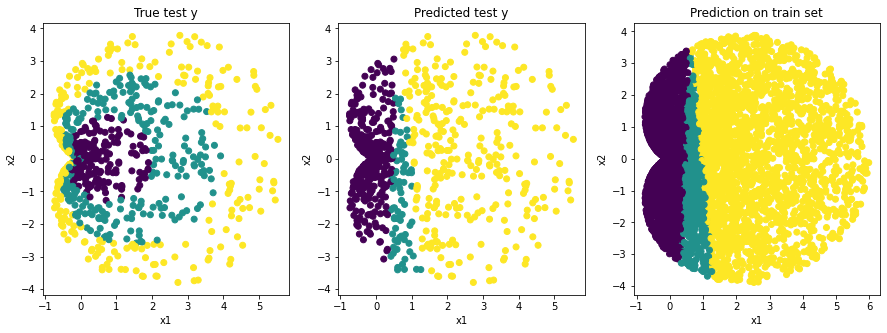

Epoch:  2000 Accuracy:  41.199999999999996 %


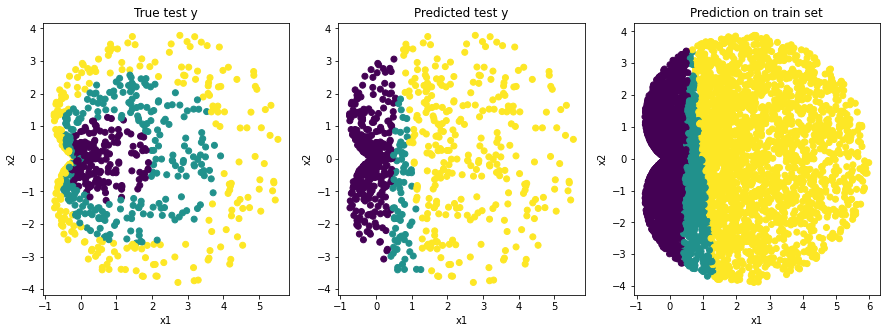

Epoch:  2200 Accuracy:  41.199999999999996 %


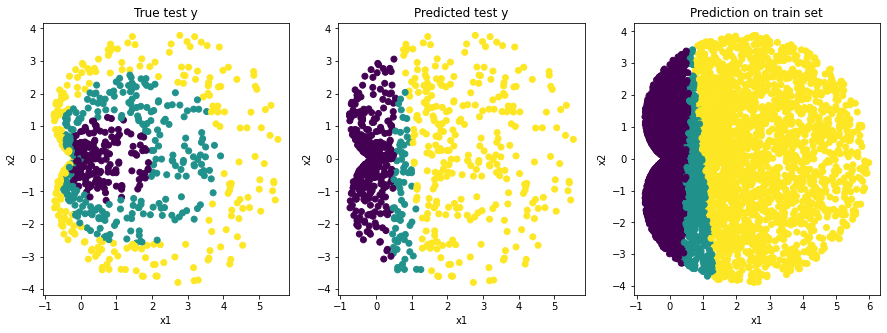

Epoch:  2400 Accuracy:  41.6 %


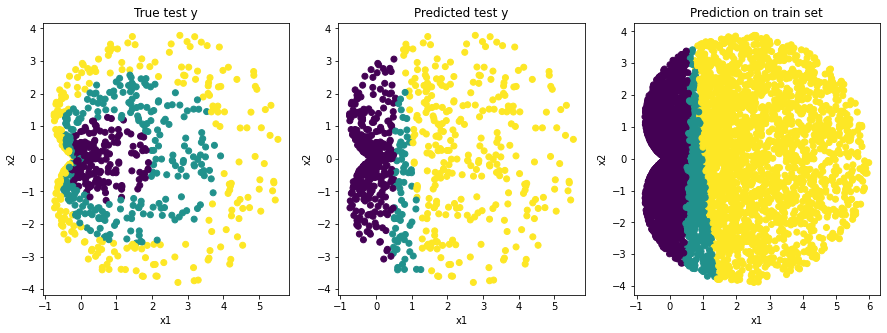

Epoch:  2600 Accuracy:  41.8 %


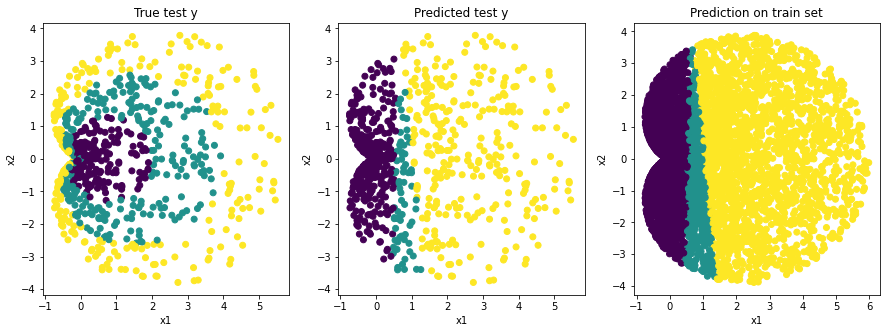

Epoch:  2800 Accuracy:  41.9 %


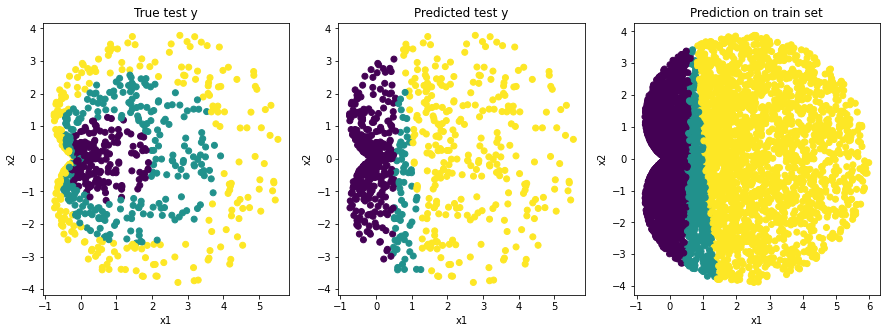

Epoch:  3000 Accuracy:  41.9 %


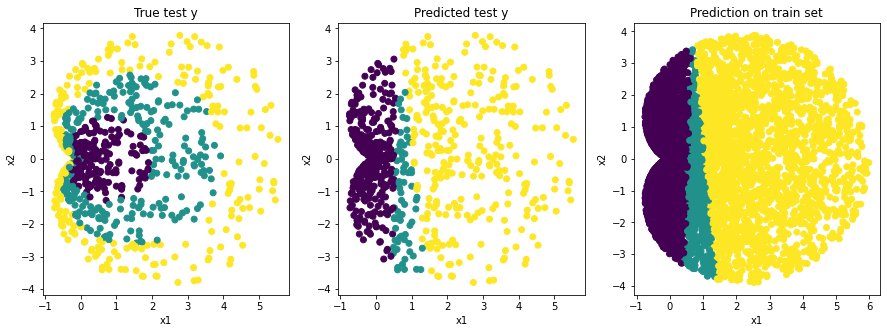

Epoch:  3200 Accuracy:  41.8 %


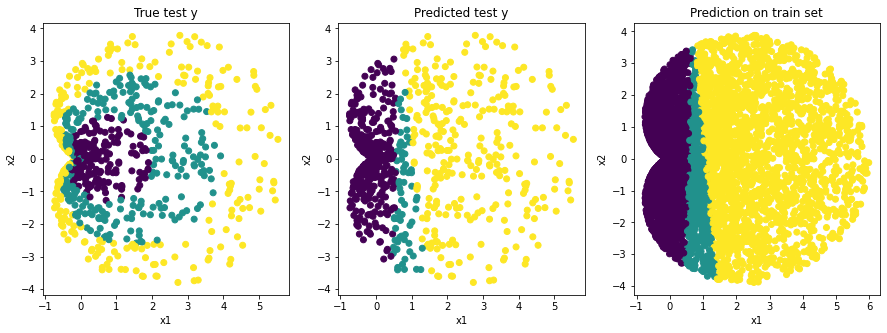

Epoch:  3400 Accuracy:  41.8 %


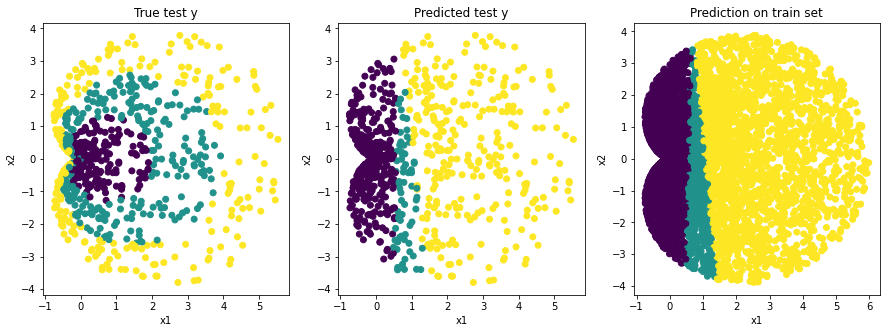

Epoch:  3600 Accuracy:  41.6 %


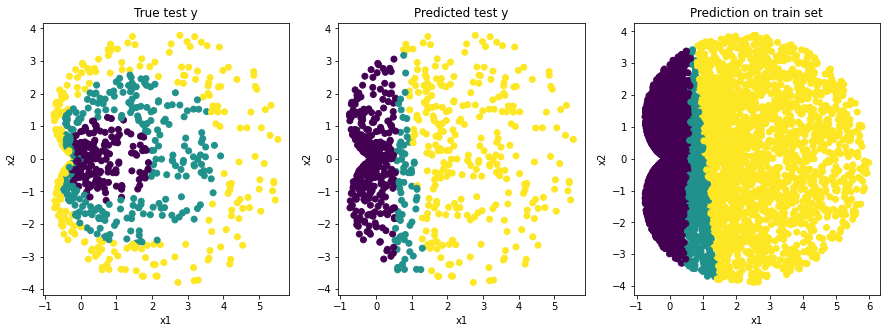

Epoch:  3800 Accuracy:  41.4 %


In [54]:
#matplotlib inline

import torch.optim as optim
from sklearn.metrics import accuracy_score

# Construct Model
model = LinearModel()
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.

# Construct Optimizer
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr)

list_epoch = []
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 4000
for i in range(epoch):
    # Train
    model.train()
    optimizer.zero_grad()
    
    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y).long()
    pred_y = model(input_x)
    
    loss = cls_loss(pred_y.squeeze(), true_y)
    loss.backward()
    optimizer.step()
    list_epoch.append(i)
    list_train_loss.append(loss.item())
    
    # Validation
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y).long()
    pred_y = model(input_x)
    loss = cls_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.item())
    
    # Evaluation
    if i % 200 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
        
        # ====== Calculate Accuracy ====== #
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        acc = accuracy_score(true_y, pred_y) # sklearn 쪽 함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것에 주의합시다
        list_acc.append(acc)
        list_acc_epoch.append(i)

        fig = plt.figure(figsize=(15,5))
        
        # ====== True Y Scattering ====== #
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_title('True test y')
        
        # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.scatter(test_X[:, 0], test_X[:, 1], c=pred_y)
        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_title('Predicted test y')
        
        # ====== Just for Visualizaing with High Resolution ====== #
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.scatter(train_X[:, 0], train_X[:, 1], c=pred_y)
        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_title('Prediction on train set')

        plt.show()
        print('Epoch: ', i,  'Accuracy: ', acc*100, '%')

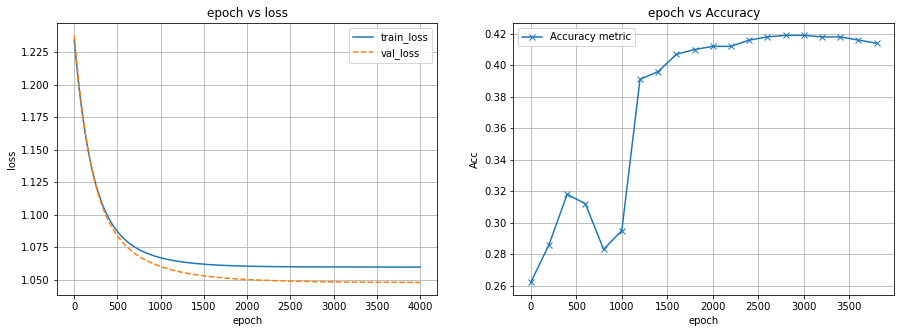

In [55]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()